# Simulated MR artifacts (torchio)

In [1]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
import os
if os.path.isdir('/content/misas'):
    os.chdir('/content/misas')

In [2]:
#hide
import warnings
warnings.filterwarnings('ignore')

In [3]:
#default_exp mri

If you use these transformations which all build on TorchIO, please cite the following paper:
> Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696

In [4]:
#exporti
from torchio.transforms import Spike

## Spike artifact

In [5]:
#exporti
from fastai.vision import open_image, Image, open_mask
from misas.core import Fastai1_model, get_generic_series, plot_series, eval_generic_series
from functools import partial
import torch

In [6]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [7]:
#export
def spikeTransform(image, intensityFactor, spikePosition=[.1,.1]):
    data = image.data[0].unsqueeze(0)
    spikePosition = [[0.0] + spikePosition]
    spike = Spike(spikePosition, intensityFactor)
    data = spike.add_artifact(data, spikePosition, intensityFactor)[0]
    data = torch.stack((data,data,data))
    return Image(torch.clamp(data,0,1))

def get_spike_series(image, model, start=0, end=2.5, step=.5, spikePosition=[.1,.1], **kwargs):
    return get_generic_series(image,model,partial(spikeTransform,spikePosition=spikePosition), start=start, end=end, step=step, **kwargs)

In [8]:
fname = "example/b0/images/val_example_0.png"
img = lambda: open_image(fname).resize(256)
trueMask = lambda: open_mask(fname.replace("image","mask"))

In [9]:
def interactiveSpikeTransform(intensity, x, y):
    spikeTransform(img(), intensity, [x,y]).show(figsize=(8,8))

In [10]:
interactive_plot = interactive(
    interactiveSpikeTransform,
    intensity=widgets.FloatSlider(min=0, max=3, step=.1, value=1, continuous_update=True),
    x=widgets.FloatSlider(min=0, max=.99, step=.05, value=.5, continuous_update=True),
    y=widgets.FloatSlider(min=0, max=.99, step=.05, value=.5, continuous_update=True)
)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='intensity', max=3.0), FloatSlider(value=0.5, descrip…

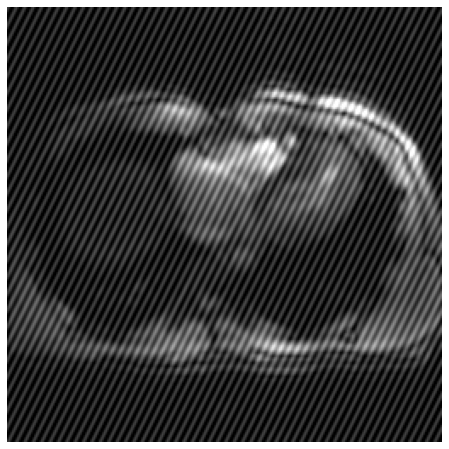

In [11]:
spikeTransform(img(), .8, [.4,.3]).show(figsize=(8,8), cmap="bone")

In [12]:
trainedModel = Fastai1_model('chfc-cmi/transversal-cmr-seg', 'b0_transversal_5_5')

Using cache found in /home/jovyan/.cache/torch/hub/chfc-cmi_transversal-cmr-seg_master


In [13]:
series = get_spike_series(img(), trainedModel, truth=trueMask(), tfm_y=False)

  0%|          | 0/5 [00:00<?, ?it/s]

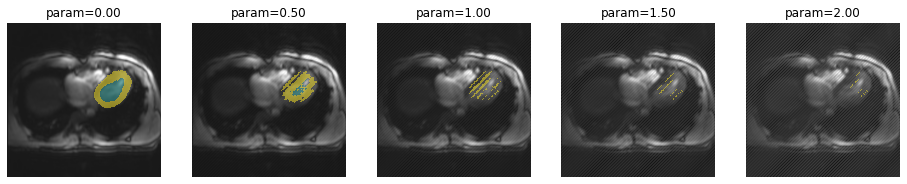

In [14]:
plot_series(series)

  0%|          | 0/5 [00:00<?, ?it/s]

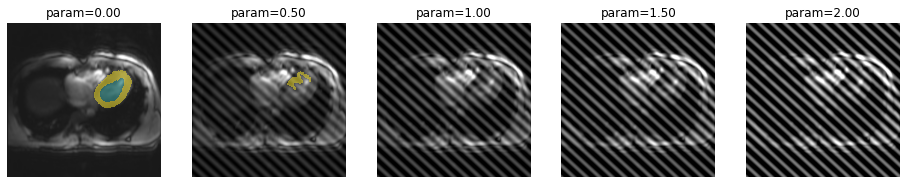

In [15]:
spikePosition = [.45,.55]
plot_series(get_spike_series(img(), trainedModel, truth=trueMask(), spikePosition=spikePosition))

  0%|          | 0/5 [00:00<?, ?it/s]

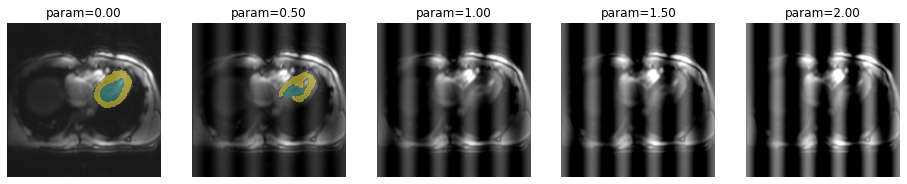

In [16]:
spikePosition = [.5,.52]
plot_series(get_spike_series(img(), trainedModel, truth=trueMask(), spikePosition=spikePosition))

In [17]:
#export
def eval_spike_series(image, mask, model, step=.1, start=0, end=2.5, spikePosition=[.1,.1], **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        partial(spikeTransform,spikePosition=spikePosition),
        start=start,
        end=end,
        step=step,
        mask_transform_function=None,
        param_name="intensity",
        **kwargs
    )

  0%|          | 0/25 [00:00<?, ?it/s]

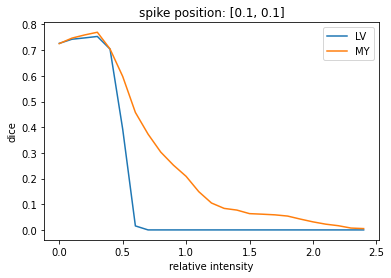

In [18]:
results = eval_spike_series(img(), trueMask(), trainedModel)
plt.plot(results['intensity'], results['c1'], label='LV')
plt.plot(results['intensity'], results['c2'], label='MY')
plt.legend()
plt.xlabel('relative intensity')
plt.ylabel('dice')
_ = plt.title(f'spike position: {[.1,.1]}')

## Bias Field ($B_0$)

The bias field function is still experimental as it lacks configurability. To make it deterministic all coefficients are set to the exact same value. This represents only one specific possibility of field inhomogeneity.

In [19]:
#exporti
from torchio import RandomBiasField, BiasField

In [20]:
data = img().data[0].unsqueeze(0).unsqueeze(0)

In [21]:
coefficients = RandomBiasField().get_params(3,[-.3,-.3])

In [22]:
bf = BiasField.generate_bias_field(data, order=3, coefficients=coefficients)

In [23]:
bf[0].min()

0.049787063

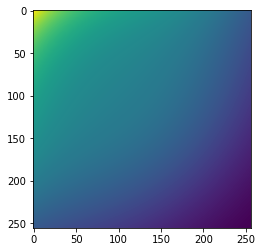

In [24]:
plt.imshow(bf[0])

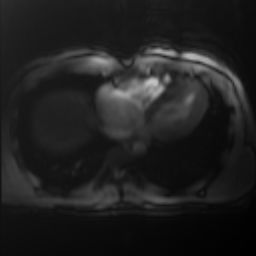

In [25]:
result = data[0][0] * bf[0]
result = torch.stack((result,result,result))
Image(result.clamp(0,1))

In [26]:
#export
def biasfieldTransform(image, coef, order=3):
    data = image.data[0].unsqueeze(0).unsqueeze(0)
    coefficients = RandomBiasField().get_params(3,[coef,coef])
    bf = BiasField.generate_bias_field(data, order=3, coefficients=coefficients)
    bf[0] = torch.clamp(torch.Tensor(bf[0]),0,1)
    data = data[0][0] * bf[0]
    data = torch.stack((data,data,data))
    return Image(data)

def get_biasfield_series(image, model, start=0, end=-.6, step=-.2, order=3, **kwargs):
    return get_generic_series(image,model,partial(biasfieldTransform,order=order), start=start, end=end, step=step, **kwargs)

  0%|          | 0/6 [00:00<?, ?it/s]

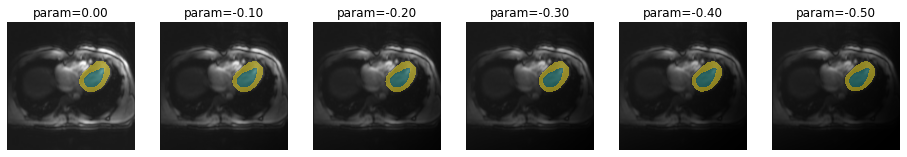

In [27]:
plot_series(get_biasfield_series(img(),trainedModel,step=-.1),nrow=1)

In [28]:
#export
def eval_biasfield_series(image, mask, model, step=-.05, start=0, end=-.55, order=3, **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        partial(biasfieldTransform,order=order),
        start=start,
        end=end,
        step=step,
        mask_transform_function=None,
        param_name="coefficient",
        **kwargs
    )

  0%|          | 0/11 [00:00<?, ?it/s]

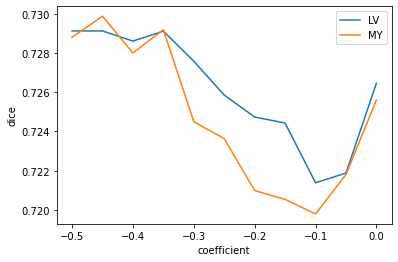

In [29]:
results = eval_biasfield_series(img(), trueMask(), trainedModel)
plt.plot(results['coefficient'], results['c1'], label='LV')
plt.plot(results['coefficient'], results['c2'], label='MY')
plt.legend()
plt.xlabel('coefficient')
_ = plt.ylabel('dice')